# (Kaggle PetFinder) TabNet

PyTorch implementation from [dreamquark-ai](https://github.com/dreamquark-ai/tabnet).

In [1]:
!pip install pytorch-tabnet -q
!pip install pandas -q
!pip install matplotlib -q
!pip install catboost -q
!pip install scikit-optimize -q

## Imports

In [2]:
import pandas as pd
import numpy as np
import json
import numpy as np
import os, time, shutil
import pickle as cpk
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import itertools
from scipy.stats import randint, uniform
from IPython.core.display import display, HTML
import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler

## Helper functions

In [3]:
def save_artifact(o, path):
    with open(path, "wb") as output_file:
        cpk.dump(o, output_file)
        
def load_artifact(path):
    with open(path, "rb") as input_file:
        o = cpk.load(input_file)
    return o

def split_data(df, n=3):
    X_train, X_valid, y_train, y_valid = train_test_split(df, df.adoptionspeed, test_size=0.33, random_state=42, stratify=df.adoptionspeed)

    speedy = X_train.loc[X_train.adoptionspeed==0]
    for _ in range(n): 
        X_train = X_train.append(speedy)
        y_train = y_train.append(speedy.adoptionspeed)  
        
    return X_train, X_valid, y_train, y_valid

def kappa(y_true, y_pred): return cohen_kappa_score(y_true, y_pred, weights='quadratic')
def accuracy(y_true, y_pred): return accuracy_score(y_true, y_pred)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix validation set',
                          cmap=plt.cm.Blues):
    """
    plot_confusion_matrix prints and plots the cm 
    confusion matrix received in input.
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(b=None)
    
def report(m, X, y_valid, preds=None, classes=[0, 1, 2, 3, 4], conf=True, verbose=True):
    p = m.predict(X) if preds is None else preds
    cm = confusion_matrix(y_valid, p)
    if verbose: print(f"Accuracy: {np.round(accuracy(y_valid, p),5)}\nCohen's Kappa: {np.round(kappa(y_valid, p),5)}\nKaggle winning Cohen's Kappa: 0.45338\n")
    if conf: plot_confusion_matrix(cm, classes)
    return {'accuracy': accuracy(y_valid, p), 'kappa': kappa(y_valid, p)}

def categorify(df, catf, d=None):
    if d is None:
        d = {}
        for c in catf:
            df[c] = df[c].astype('category') #.as_ordered()
            d[c] = df[c].cat.categories
            df[c] = df[c].cat.codes+1
    else:
        for c in catf:
            df[c] = pd.Categorical(df[c], categories=d[c])
            df[c] = df[c].cat.codes+1
            df[c] = df[c].fillna(0)

    return df, d

def apply_cats(df, trn):
    for c in trn.columns:
        df[c] = pd.Categorical(df[c], categories=trn[c].cat.categories)

def split_cats(df, catf): return catf, [col for col in df.columns if col not in catf]

def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, int(round(1.6 * n_cat**0.56)))

def get_nlp_feats():
    nlp_feats = pd.read_csv("nlp.csv").set_index('petid')
    return nlp_feats[[f for f in nlp_feats.columns if "vec" in f]]
    
def get_cv_feats():
    cv_feats = pd.read_csv("cv.csv").set_index('petid')
    return cv_feats[[f for f in cv_feats.columns if "cv" in f]]

## Loading data

In [4]:
cv_feats = get_cv_feats()
nlp_feats = get_nlp_feats()

artifacts = load_artifact('artifacts.pkl')
features = artifacts['features']
feats = [f for f in features if "vec" not in f and "cv" not in f]
raw_train = artifacts['X_train']
raw_valid = artifacts['X_valid']
cats_ = artifacts['cat_feats']

raw_train = raw_train[feats+['petid', 'adoptionspeed']].set_index('petid').join(cv_feats, how="inner").join(nlp_feats, how="inner")
raw_valid = raw_valid[feats+['petid', 'adoptionspeed']].set_index('petid').join(cv_feats, how="inner").join(nlp_feats, how="inner")

y_train = raw_train.adoptionspeed
y_valid = raw_valid.adoptionspeed
raw_train.drop('adoptionspeed', inplace=True, axis=1)
raw_valid.drop('adoptionspeed', inplace=True, axis=1)

assert 'adoptionspeed' not in raw_train.columns
assert 'adoptionspeed' not in raw_valid.columns

In [5]:
raw_train.head()

,age,len_desc,quantity,fee,photoamt,magnitude,name,breed1,breed2,gender,...,vec_190,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199
petid,,,,,,,,,,,,,,,,,,,,,
000fb9572,2,30.0,1,0,6.0,0.8,Minnie,307,0,2,...,-0.204805,-0.120394,-0.203883,0.140123,0.146703,-0.023518,0.004772,-0.256093,0.186037,0.136628
0011d7c25,2,9.0,1,0,3.0,0.8,Spot,241,241,1,...,-0.103921,-0.254193,-0.368831,0.092267,-0.111209,0.021954,-0.141817,-0.156179,0.117617,0.020803
00156db4a,1,82.0,1,0,5.0,1.8,Pup,307,0,1,...,-0.015124,-0.168721,-0.199162,0.106704,0.066061,-0.151983,-0.015352,-0.138054,0.188798,0.097827
001a1aaad,7,121.0,2,0,4.0,3.5,Cookie & Leo,265,0,1,...,0.014736,-0.092469,-0.139565,0.196030,0.020342,-0.177693,-0.008069,-0.107937,0.129181,0.077736
001b1507c,2,148.0,1,50,6.0,4.7,Grey Baby Girl,266,265,2,...,-0.055010,-0.178267,-0.020247,0.081800,0.053436,0.019179,-0.065842,-0.213648,0.174046,0.095165


In [6]:
catf, numf = split_cats(raw_train, cats_)
len(catf), len(numf)

(15, 718)

In [7]:
X_train, d_cats = categorify(raw_train, catf)

In [8]:
X_train.head()

,age,len_desc,quantity,fee,photoamt,magnitude,name,breed1,breed2,gender,...,vec_190,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199
petid,,,,,,,,,,,,,,,,,,,,,
000fb9572,2,30.0,1,0,6.0,0.8,3865,155,1,2,...,-0.204805,-0.120394,-0.203883,0.140123,0.146703,-0.023518,0.004772,-0.256093,0.186037,0.136628
0011d7c25,2,9.0,1,0,3.0,0.8,5454,104,73,1,...,-0.103921,-0.254193,-0.368831,0.092267,-0.111209,0.021954,-0.141817,-0.156179,0.117617,0.020803
00156db4a,1,82.0,1,0,5.0,1.8,4724,155,1,1,...,-0.015124,-0.168721,-0.199162,0.106704,0.066061,-0.151983,-0.015352,-0.138054,0.188798,0.097827
001a1aaad,7,121.0,2,0,4.0,3.5,1533,123,1,1,...,0.014736,-0.092469,-0.139565,0.196030,0.020342,-0.177693,-0.008069,-0.107937,0.129181,0.077736
001b1507c,2,148.0,1,50,6.0,4.7,2401,124,91,2,...,-0.055010,-0.178267,-0.020247,0.081800,0.053436,0.019179,-0.065842,-0.213648,0.174046,0.095165


In [9]:
X_valid, _ = categorify(raw_valid, catf, d_cats)

In [10]:
X_valid.head()

,age,len_desc,quantity,fee,photoamt,magnitude,name,breed1,breed2,gender,...,vec_190,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199
petid,,,,,,,,,,,,,,,,,,,,,
dd7ad37e7,24,28.0,1,0,1.0,1.5,0,140,1,1,...,-0.258114,-0.147105,0.017356,0.133638,0.025135,0.070112,-0.080308,-0.056084,0.122768,-0.063339
518f86025,3,62.0,1,1,2.0,1.0,3556,155,120,1,...,0.048094,-0.160050,-0.161059,0.114607,0.032491,-0.048000,-0.154846,-0.226307,0.194863,0.242098
8ba1566de,1,3.0,5,0,1.0,0.2,0,130,1,3,...,-0.371357,0.053040,-0.145598,0.500731,0.594119,-0.043963,-0.045302,0.137303,0.091446,0.050955
e5bc7aaa8,2,84.0,3,0,3.0,1.1,0,123,1,3,...,0.017502,-0.160287,-0.169785,0.111007,0.130656,-0.108504,0.002038,-0.180873,0.275565,0.238183
a0c9daa0a,2,27.0,1,0,1.0,0.2,6317,155,1,2,...,-0.028276,-0.070629,-0.188597,0.098899,0.029050,-0.132318,-0.021146,-0.273660,0.166280,0.132679


In [11]:
cat_sz = [(c, X_train[c].max()+1) for c in catf]
cat_sz

[('name', 6392),
 ('breed1', 156),
 ('breed2', 121),
 ('gender', 4),
 ('color1', 8),
 ('color2', 8),
 ('color3', 7),
 ('maturitysize', 5),
 ('furlength', 4),
 ('vaccinated', 4),
 ('dewormed', 4),
 ('sterilized', 4),
 ('health', 4),
 ('lang', 6),
 ('state', 15)]

In [12]:
emb_szs = [(c, emb_sz_rule(c)) for _,c in cat_sz]
emb_szs

[(6392, 216),
 (156, 27),
 (121, 23),
 (4, 3),
 (8, 5),
 (8, 5),
 (7, 5),
 (5, 4),
 (4, 3),
 (4, 3),
 (4, 3),
 (4, 3),
 (4, 3),
 (6, 4),
 (15, 7)]

## TabNet

In [13]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [14]:
cat_idxs = [i for i,f in enumerate(list(X_train.columns)) if f in catf]
cat_dims = [el[0] for el in emb_szs]
cat_emb_dim = [el[1] for el in emb_szs]

In [15]:
cat_dims, cat_emb_dim, cat_idxs

([6392, 156, 121, 4, 8, 8, 7, 5, 4, 4, 4, 4, 4, 6, 15],
 [216, 27, 23, 3, 5, 5, 5, 4, 3, 3, 3, 3, 3, 4, 7],
 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [16]:
X_train.shape, X_valid.shape

((10870, 733), (4948, 733))

Device used : cpu
Will train until validation stopping metric hasn't improved in 10 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.21297 |  0.22918 |   24.0      
| 2     | 0.22015 |  0.25829 |   47.6      
| 3     | 0.22898 |  0.24757 |   70.1      
| 4     | 0.23385 |  0.24091 |   90.8      
| 5     | 0.23993 |  0.24111 |   111.6     
| 6     | 0.26799 |  0.27284 |   132.6     
| 7     | 0.26817 |  0.27001 |   153.3     
| 8     | 0.27286 |  0.28496 |   174.1     
| 9     | 0.24223 |  0.27445 |   195.0     
| 10    | 0.26854 |  0.29406 |   216.0     
| 11    | 0.26523 |  0.27567 |   237.0     
| 12    | 0.26946 |  0.29689 |   258.0     
| 13    | 0.26550 |  0.28416 |   279.0     
| 14    | 0.28123 |  0.29810 |   299.9     
| 15    | 0.28132 |  0.29082 |   320.9     
| 16    | 0.28307 |  0.28416 |   341.8     
| 17    | 0.27746 |  0.30396 |   362.8     
| 18    | 0.29016 |  0.30437 |   383.8     
| 19    | 0.29255 |  0.32215 |

{'accuracy': 0.3221503637833468, 'kappa': 0.14550787525234266}

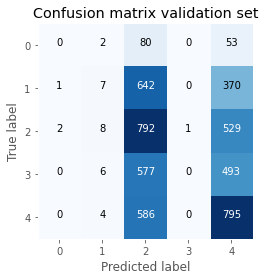

In [25]:
clf = TabNetClassifier(
    n_d=32, 
    n_a=32, 
    n_steps=8,
    gamma=2.0,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3, #cat_emb_dim,
    lambda_sparse=1e-3,
    optimizer_params=dict(lr=2e-2)
)

clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    X_valid=X_valid.values, y_valid=y_valid.values
) 

report(clf, X_valid.values, y_valid.values)

In [23]:
import random
params = {
        'n_d': [8, 16, 24, 32, 64, 128],
        'n_steps': [3, 4, 5, 6, 7, 8, 9, 10],
        'lambda_sparse': [0, 0.000001, 0.0001, 0.001, 0.01, 0.1],
        'gamma': [1.0, 1.2, 1.5, 2.0]
    }

l_args = []
for _ in range(10):
    args={}
    for k in params.keys():
        args[k] = random.sample(params[k], 1)[0]
    args['n_a'] = args['n_d']
    l_args.append(args)

In [24]:
def train_report(args):
    clf = TabNetClassifier(
                        cat_idxs=cat_idxs,
                        cat_dims=cat_dims,
                        cat_emb_dim=cat_emb_dim,
                        verbose=0,
                        optimizer_params=dict(lr=2e-1),
                        **args
                    )
    
    clf.fit(X_train=X_train.values, y_train=y_train.values,
            X_valid=X_valid.values, y_valid=y_valid.values) 

    res = report(clf, X_valid.values, y_valid.values, conf=False, verbose=False)
    res['clf'] = clf
    args.update(res)
    return args

In [25]:
hpo = []

for i, ar in enumerate(l_args):
    print(i, ar)
    hpo.append(train_report(ar))

0 {'n_d': 32, 'n_steps': 8, 'lambda_sparse': 0.001, 'gamma': 1.0, 'n_a': 32}
Device used : cpu
1 {'n_d': 8, 'n_steps': 9, 'lambda_sparse': 1e-06, 'gamma': 2.0, 'n_a': 8}
Device used : cpu
2 {'n_d': 64, 'n_steps': 4, 'lambda_sparse': 0.001, 'gamma': 2.0, 'n_a': 64}
Device used : cpu
3 {'n_d': 24, 'n_steps': 10, 'lambda_sparse': 0.0001, 'gamma': 1.5, 'n_a': 24}
Device used : cpu
4 {'n_d': 64, 'n_steps': 5, 'lambda_sparse': 0, 'gamma': 1.0, 'n_a': 64}
Device used : cpu
5 {'n_d': 24, 'n_steps': 8, 'lambda_sparse': 1e-06, 'gamma': 1.0, 'n_a': 24}
Device used : cpu
6 {'n_d': 32, 'n_steps': 7, 'lambda_sparse': 0.001, 'gamma': 1.2, 'n_a': 32}
Device used : cpu
7 {'n_d': 32, 'n_steps': 5, 'lambda_sparse': 0.0001, 'gamma': 1.0, 'n_a': 32}
Device used : cpu
8 {'n_d': 16, 'n_steps': 7, 'lambda_sparse': 0, 'gamma': 2.0, 'n_a': 16}
Device used : cpu
9 {'n_d': 24, 'n_steps': 8, 'lambda_sparse': 0, 'gamma': 1.2, 'n_a': 24}
Device used : cpu


In [26]:
pd.DataFrame(hpo).drop(columns="clf").sort_values(by='kappa', ascending=False)

,n_d,n_steps,lambda_sparse,gamma,n_a,accuracy,kappa
2,64,4,0.001000,2.0,64,0.337510,0.233481
7,32,5,0.000100,1.0,32,0.298504,0.139188
6,32,7,0.001000,1.2,32,0.304568,0.131057
4,64,5,0.000000,1.0,64,0.300121,0.117108
0,32,8,0.001000,1.0,32,0.308205,0.112620
9,24,8,0.000000,1.2,24,0.289410,0.106326
5,24,8,0.000001,1.0,24,0.289006,0.104257
1,8,9,0.000001,2.0,8,0.296888,0.096703
3,24,10,0.000100,1.5,24,0.299717,0.072063
8,16,7,0.000000,2.0,16,0.286985,0.047516


In [27]:
save_artifact(hpo, 'hpo_tabnet.pkl')

/usr/local/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
